In [7]:
# Создаем соединение c базой данных (Для того, чтобы определить данные для подключения с базой данных 
# необходимо зайти в Posgresql, после введения пользовательского пароля, кликаем "Servers", 
# затем кликаем правой кнопкой мыши, в сплывающем окне выбираем "Properties", переходим в раздел "Connection".
# В этом разделе отображены все данные, необходимые для соединения с базой данных. 

import psycopg2 # драйвер для postgresql
import getpass  # эта функция скрывает пароль, можно не вводить данную функцию, 
# тогда в строке password вам необходимо указать свой пароль от базы данных 

conn=psycopg2.connect(user='postgres',
                      database='postgres',
                      host='localhost',
                      port='5433',
                      password=getpass.getpass('Insert password: ')
                        )
print(conn.get_dsn_parameters())


Insert password: ········
{'user': 'postgres', 'dbname': 'postgres', 'host': 'localhost', 'port': '5433', 'tty': '', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'}


In [35]:
import pandas as pd


# Запрос, который выводит таблицу с рейтингом и типом рейтинга при условии, что используется школа агенства Эксперт РА 
# В строке \"DATE\" >=  AND \"DATE\" <=   пользователь может задать любой необходимый промежуток времени


query = """SELECT rating_task1.\"GRADE\", rating_task1.\"RAT_TYPE\" 
FROM rating_task1 
WHERE "AGENCY_ID" = 'EXP'
AND \"DATE\" >= '2014/01/01' AND \"DATE\" <= '2015/01/01' 
AND \"CHANGE\" != 'снят' AND \"CHANGE\" != 'приостановлен'"""

ratings=pd.read_sql_query(query, conn)
ratings


,GRADE,RAT_TYPE
0,A+,FS&R
1,B+,Cr&D
2,B++,Cr&D
3,A++,FS&R
4,A,Cr&D
...,...,...
836,A,Cr&D
837,A+,FS&R
838,A,Cr&D
839,A+,R&QS


In [47]:
# С помощью функции pivot создается таблица, в которой отображается количество компаний, 
# допустивших и недопустивших дефолт на заданном промежутке времени, которые, в свою очередь, сгруппированны по grade

ratings1 = ratings[['GRADE', 'RAT_TYPE']]
ratings1['default'] = ratings1['RAT_TYPE']
ratings1['default'] = ratings1['default'].replace(to_replace = {'Cr&D': 'default', 'FS&R': 'non-default', 'R&QS': 'non-default'})
ratings1 = ratings1.pivot_table(index = 'GRADE', columns = 'default', aggfunc = 'count')
ratings1 = ratings1.replace(to_replace = {float('nan'): 0})
ratings1

RAT_TYPE            
default  default non-default
GRADE                       
A          304.0        91.0
A+         103.0        75.0
A++         13.0        71.0
A++.mfi      0.0         4.0
A+.mfi       0.0        12.0
A.mfi        0.0        17.0
B            3.0         3.0
B+          12.0         5.0
B++         79.0        16.0
B++.mfi      0.0         2.0
BBB          2.0         0.0
BBB-         1.0         0.0
C            4.0         0.0
C+           6.0         2.0
C++          3.0         1.0
E           11.0         1.0

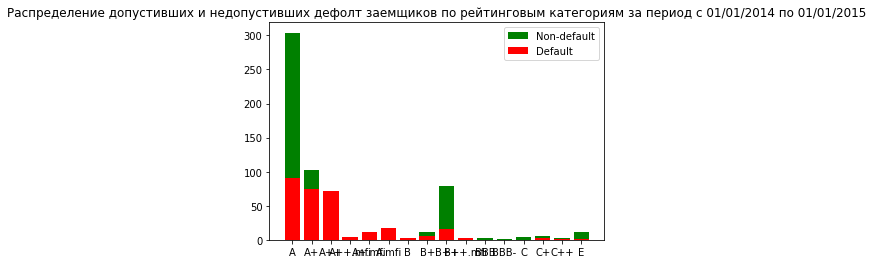

In [46]:
import matplotlib.pyplot as plt

# Создание графика вида bar с заданными цветами для разных групп, для допустивших дефолт - красный, для недопустивших дефолт - зеленый

plt.bar(ratings1.index.values, ratings1['RAT_TYPE']['default'].values, label = 'Non-default', color = 'g')
plt.bar(ratings1.index.values, ratings1['RAT_TYPE']['non-default'].values,  label = 'Default', color = 'r')

# Добавление легенды
plt.legend()

# Добавление заголовка 
plt.title('Распределение допустивших и недопустивших дефолт заемщиков по рейтинговым категориям за период с 01/01/2014 по 01/01/2015')

plt.show()

In [55]:
# Эмпирические функции распределения недефолтеров и дефолтеров по рейтинговым категориям

ratings2 = pd.DataFrame(index = ratings1.index)
ratings2['default_cumsum'] = ratings2['default'].cumsum()/ratings2['default'].sum()
ratings2['non-default_cumsum'] = ratings2['non-default'].cumsum()/ratings2['non-default'].sum()
ratings2 = ratings2[['default_cumsum', 'non-default_cumsum']]

ratings2.plot(kind = 'bar', figsize = [10,10], fontsize = 10)
plt.show()

KeyError: 'default'